## RFM Analysis on E-commerce Data

RFM is method of customer behavioral segmentation based on 3 key features:
- Recency: How recently a customer did a certain activity (in this case, made a purchase, measured by number of days since the last purchase).
- Frequency: How often a customer made purchases (measured by the number of transaction).
- Monetary Value: The amount of money spent on those purchases.

We will perform RFM analysis on a dataset from a UK-based and registered, non-store online retail company, containing all the transactions occurring between 01/12/2009 and 09/12/2011.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import os

### Details about the Dataset
An e-commerce company wants to segment its customers and determine marketing strategies according to these segments. To this end, we will define the behavior of customers and create groups according to clusters in these behaviors. In other words, we will include those who exhibit common behaviors in the same groups and we will try to develop special sales and marketing techniques for these groups.

- InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invoice date and time. Numeric. The day and time when a transaction was generated.
- UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
- CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal. The name of the country where a customer resides.

### Load the Data

In [2]:
os.chdir('/Users/neera/Documents/PROJECTS/RFM Analysis')
df = pd.read_csv('online_retail_listing.csv', delimiter=';', encoding='latin-1')

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,1.12.2009 07:45,"6,95",13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,1.12.2009 07:45,"6,75",13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,1.12.2009 07:45,"6,75",13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,1.12.2009 07:45,"2,1",13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.12.2009 07:45,"1,25",13085.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
Invoice        1048575 non-null object
StockCode      1048575 non-null object
Description    1044203 non-null object
Quantity       1048575 non-null int64
InvoiceDate    1048575 non-null object
Price          1048575 non-null object
Customer ID    811893 non-null float64
Country        1048575 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 64.0+ MB


We can see that there are some rows with null values in Customer ID and Description. We need to drop these rows.

In [5]:
df = df.dropna()

Moreover, the Price column's datatype is object. We need to convert it into float and replace the comma.
<br>
We also need to add a new column for the total amount of money spent, which is Price times Quantity.

In [6]:
df['Price'] = df['Price'].apply(lambda x: float(str(x.replace(',','.'))))
df['TotalPrice'] = df['Quantity'] * df['Price']

Convert InvoiceDate into the date format.

In [7]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

Filter out the cancelled items indicated by 'C' in the Invoice column.

In [8]:
df = df[~df['Invoice'].str.contains('C', na=False)]

In [9]:
df.describe()

,Quantity,Price,Customer ID,TotalPrice
count,793380.000000,793380.000000,793380.000000,793380.000000
mean,13.221014,3.214344,15331.894511,21.836865
std,113.376231,29.363135,1696.362302,122.834624
min,1.000000,0.000000,12346.000000,0.000000
25%,2.000000,1.250000,13979.000000,4.950000
50%,5.000000,1.950000,15271.000000,11.900000
75%,12.000000,3.750000,16801.000000,19.500000
max,74215.000000,10953.500000,18287.000000,77183.600000


To calculate recency, we will be taking one day after the last invoice date of our data set as the 'present' date. The date difference will give us how recent the last transaction was made.

In [10]:
df['InvoiceDate'].max()

Timestamp('2011-12-10 17:19:00')

In [11]:
present_date =  dt.datetime(2011,12,11)

Then we group our dataframe (specifically the InvoiceDate, InvoiceNo, and TotalPrice) by customer ID and assign it into a new dataframe.

In [12]:
rfm = df.groupby('Customer ID').agg({'InvoiceDate' : lambda day : (present_date - day.max()).days,
                               'Invoice': lambda num: num.nunique(),
                              'TotalPrice': lambda price : price.sum()
})
cols = ['Recency','Frequency','Monetary']
rfm.columns = cols

In [13]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 5863 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
Recency      5863 non-null int64
Frequency    5863 non-null int64
Monetary     5863 non-null float64
dtypes: float64(1), int64(2)
memory usage: 183.2 KB


We have 5863 customer records with the recency of their purchase, the frequency by their quantity, and the monetary value of the purchases. Then we will calculate the RFM Score by dividing each column into 5 bins.

In [14]:
rfm['R'] = pd.cut(rfm['Recency'], 
                                       bins=[-1, 
                                             np.percentile(rfm['Recency'], 20), 
                                             np.percentile(rfm['Recency'], 40), 
                                             np.percentile(rfm['Recency'], 60),
                                             np.percentile(rfm['Recency'], 80),
                                             np.percentile(rfm['Recency'], 100)], 
                                       labels=[5, 4, 3, 2, 1]).astype('int')

In [15]:
rfm['F'] = pd.cut(rfm['Frequency'], 
                                       bins=[-1, 
                                             np.percentile(rfm['Frequency'], 20), 
                                             np.percentile(rfm['Frequency'], 40), 
                                             np.percentile(rfm['Frequency'], 60),
                                             np.percentile(rfm['Frequency'], 80),
                                             np.percentile(rfm['Frequency'], 100)], 
                                       labels=[1, 2, 3, 4, 5]).astype('int')

In [16]:
rfm['M'] = pd.cut(rfm['Monetary'], 
                                       bins=[-1, 
                                             np.percentile(rfm['Monetary'], 20), 
                                             np.percentile(rfm['Monetary'], 40), 
                                             np.percentile(rfm['Monetary'], 60),
                                             np.percentile(rfm['Monetary'], 80),
                                             np.percentile(rfm['Monetary'], 100)], 
                                       labels=[1, 2, 3, 4, 5]).astype('int')

The reason I'm using cut and not qcut is:
<br>
Qcut (quantile-cut) differs from cut in the sense that, in qcut, the number of elements in each bin will be roughly the same, but this will come at the cost of differently sized interval widths. On the other hand, in cut, the bin edges were equal sized with uneven number of elements in each bin or group.
<br>
So, when we ask for quintiles with qcut, the bins will be chosen so that we have the same number of records in each bin. If we have 30 records, when we specify bins = 5, they should have 6 in each bin.
<br>
Cut will choose the bins to be evenly spaced according to the values themselves and not the frequency of those values. So I use cut and dividing the bins by the percentiles.
<br>
Alternatively, using qcut with this approach will yield similar result:
<br>
rfm['R'] = pd.cut(rfm['Recency'].rank(pct=True), bins=5, labels=[5, 4, 3, 2, 1])
<br>
rfm['F'] = pd.cut(rfm['Frequency'].rank(pct=True), bins=5, labels=[1, 2, 3, 4, 5])
<br>
rfm['M'] = pd.cut(rfm['Monetary'].rank(pct=True), bins=5, labels=[1, 2, 3, 4, 5])

qcut is also not friendly with duplicated data and will throw an error when it sees a duplicate at splitting point. 
<br>
Example:

In [17]:
# rfm['R'] = pd.qcut(rfm['Recency'], q=5, labels=[5,4,3,2,1])
# rfm['F'] = pd.qcut(rfm['Frequency'], q=5, labels=[1,2,3,4,5])
# rfm['M'] = pd.qcut(rfm['Monetary'], q=5, labels=[1,2,3,4,5])
# rfm['RFM Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

# The error message: Bin edges must be unique: array([  1.,   1.,   2.,   4.,   8., 391.]).

In [18]:
rfm['RFM Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

In [19]:
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM Score
Customer ID,,,,,,,
12346.0,326,12,77556.46,2,5,5,255
12347.0,40,7,5408.50,4,4,5,445
12348.0,76,5,2019.40,3,4,4,344
12349.0,19,4,4428.69,5,3,5,535
12350.0,311,1,334.40,2,1,2,212


We will segment our customer using regex method.

In [20]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2]5': 'high_value_churned',
           r'[1-3][1-4]': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'[4-5]1': 'promising_new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'most_valuable'}

rfm['Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
Customer ID,,,,,,,,
12346.0,326,12,77556.46,2,5,5,255,high_value_churned
12347.0,40,7,5408.50,4,4,5,445,loyal_customers
12348.0,76,5,2019.40,3,4,4,344,need_attention
12349.0,19,4,4428.69,5,3,5,535,potential_loyalists
12350.0,311,1,334.40,2,1,2,212,hibernating


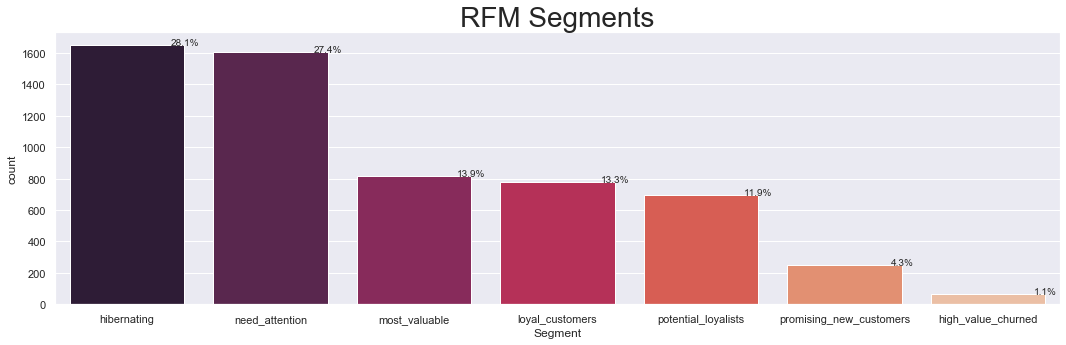

In [21]:
plt.figure(figsize=(18, 5))
total = float(len(rfm))
ax = sns.countplot(x='Segment', data=rfm, order=rfm['Segment'].value_counts().index, palette='rocket')
plt.title('RFM Segments', fontsize=28)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')
plt.show()

Most of the customers are included in the 'hibernating' (28.1%) and 'need attention' (27.4%) segment. Next we have our most valuable customers (13.9%), which are customers with the highest recency and frequency score, then the loyals, the potential loyalist, and the promising new customers. Finally, at just a little over 1%, we have the high-value customers who haven’t purchased in a while.

In [22]:
summary = (
    rfm[['Segment', 'Recency', 'Frequency', 'Monetary']]
    .groupby('Segment')
    .agg(['mean', 'median', 'count', 'min', 'max'])
)

summary.sort_values(by=('Recency', 'count'), ascending=False)

Recency                          Frequency         \
                               mean median count  min   max       mean median   
Segment                                                                         
hibernating              470.643420  444.0  1649  205  1062   1.299576      1   
need_attention           223.055314  177.0  1609   73   725   3.653822      3   
most_valuable             11.346814   11.0   816    0    23  19.012255     11   
loyal_customers           61.359435   51.0   779   24   199  12.360719     10   
potential_loyalists       31.477762   26.0   697    0    72   2.942611      3   
promising_new_customers   37.123506   36.0   251    0    72   1.000000      1   
high_value_churned       325.080645  326.5    62  205   545  16.064516     11   

                                            Monetary                         \
                        count min  max          mean   median count     min   
Segment                                                                       
hibernating              1649   1    2    442.381275   299.61  1649    0.00   
need_attention           1609   1    8   1295.185472   935.10  1609    6.20   
most_valuable             816   5  391  10541.760238  3942.93   816  389.18   
loyal_customers           779   5  140   5818.670945  3469.30   779  127.90   
potential_loyalists       697   2    4   1126.782812   795.68   697   30.95   
promising_new_customers   251   1    1    336.198287   252.10   251    0.00   
high_value_churned         62   9  155   8176.089210  4003.03    62  628.32   

                                    
                               max  
Segment                             
hibernating               13916.34  
need_attention            34095.26  
most_valuable            597336.11  
loyal_customers          193351.65  
potential_loyalists       44534.30  
promising_new_customers    1635.66  
high_value_churned        77556.46

Then we have barplots for the median of Recency, Frequency, and Monetary Value for each segment. I put the segments in the same order as our countplot above for easier comparison.

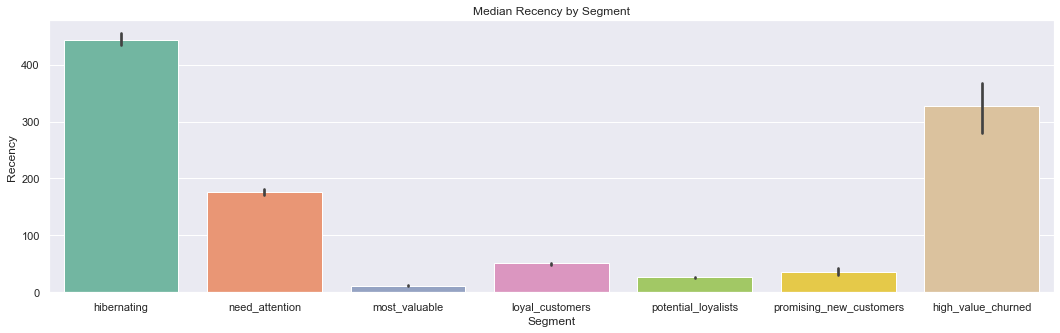

In [23]:
fig = plt.subplots(figsize=(18, 5))
sns.barplot(
    x = rfm['Segment'], 
    y = rfm['Recency'], 
    palette='Set2', 
    estimator=np.median, 
    order=rfm['Segment'].value_counts().index)
plt.title('Median Recency by Segment')
plt.show()

Here, the higher the median recency, the longer it has been since the customers' last purchase. 
<br>
The highest median belongs to the hibernating and high value churned segment. While the lowest (most recent) belongs to the most valuable customers, the loyals and potential loyalist, and the promising new customers. 

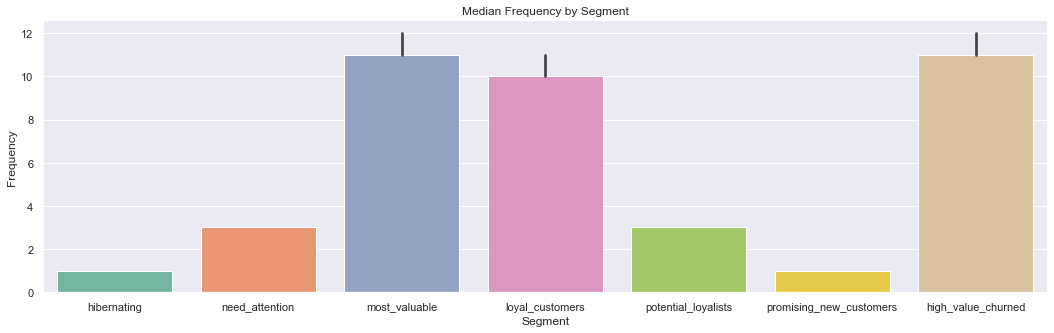

In [24]:
fig = plt.subplots(figsize=(18, 5))
sns.barplot(
    x = rfm['Segment'], 
    y = rfm['Frequency'], 
    palette='Set2', 
    estimator=np.median, 
    order=rfm['Segment'].value_counts().index)
plt.title('Median Frequency by Segment')
plt.show()

The lowest frequency belongs to the hibernating and new customers, which is not surprising. While the highest belongs to our most valuables, the loyal customers, and the high value customers who haven't made a purchase in a while. It's probably worth trying to win them back again, since they already made frequent purchases in the past.

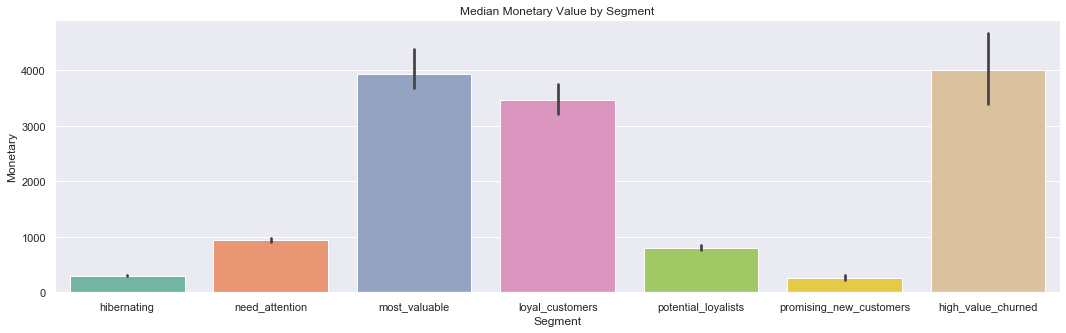

In [25]:
fig = plt.subplots(figsize=(18, 5))
sns.barplot(
    x = rfm['Segment'], 
    y = rfm['Monetary'], 
    palette='Set2', 
    estimator=np.median, 
    order=rfm['Segment'].value_counts().index)
plt.title('Median Monetary Value by Segment')
plt.show()

Customers with the highest monetary value are within the segments: most valuable, loyal customers, and high value churned. Again, one of the things that we probably should do is to try to get the churned customers back.

Examples on how to approach each segment:

- Most Valuable: These are the most valuable customers, with highest scores across the board. They tend to have higher average order value, and more likely to become loyal fans. More likely to generate referrals or word of mouth, making them more valuable. We can come up with some reward system for top, loyal customers.
- Loyal Customers: Second best to the MVPs. Retain their loyalty with rewards and personalized recommendations. We can also give points every time a customer leave a review.
- Potential Loyalists: These are the customers with high recency and low-moderate frequency. Offer membership / loyalty program. Keep them engaged. Offer personalised recommendations.
- New and Promising Customers: They have high recency score and low frequency, many of them only made a purchase once. Offer rewards or coupons. Bring them back to the platform and keep them engaged.
- Need Attention: The customers with low or moderate scores on both recency and frequency.  Offer more personalised recommendations or discounts. Don’t lose them to the competition.
- High Value Churned: Here we have high-value churned customers who haven’t purchased in a while. Win them back via new products or better reward systems.
- Hibernating: Revive interest with reach out campaign. Or we can save money on marketing by suppressing these users and improve open and click rates.